###숙소 추천

랜덤 포레스트 모델

모델 학습

In [ ]:
## 숙박 업소 추천
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# CSV 파일 경로
file_path = '/content/merged_travel_data.csv'

# CSV 파일 로드
df = pd.read_csv(file_path)

# 데이터 준비
x = df[['GENDER', 'AGE_GRP', 'TRAVEL_STYL_1', 'TRAVEL_STYL_4',
         'TRAVEL_STYL_5', 'TRAVEL_STYL_6', 'TRAVEL_STYL_8', 'TRAVEL_COMPANIONS_NUM']]
y = df['LODGING_TYPE_CD']

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 모델 성능 비교를 위한 변수 초기화
best_accuracy = 0
best_model = None

# 다양한 n_estimators 테스트
for n in [10, 30, 50, 100]:
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"n_estimators={n}: Accuracy={accuracy}, F1 Score={f1}")

    # 가장 높은 정확도의 모델 저장
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

# 최상의 모델 저장
if best_model is not None:
    with open('best_random_forest_model_type.pkl', 'wb') as f:
        pickle.dump(best_model, f)
    print("Best model saved with accuracy:", best_accuracy)

# 결과 출력
result = pd.DataFrame({'pred': y_pred, 'result': y_test})
result['matching'] = (result['pred'] == result['result'])
print(result)


n_estimators=10: Accuracy=0.7546134663341646, F1 Score=0.7506988284622881
n_estimators=30: Accuracy=0.7536159600997506, F1 Score=0.7500107807317692
n_estimators=50: Accuracy=0.7531172069825436, F1 Score=0.7507186466253559
n_estimators=100: Accuracy=0.7531172069825436, F1 Score=0.7500578630311882
Best model saved with accuracy: 0.7546134663341646
      pred  result  matching
3543     3       3      True
5731     1       1      True
4801     3       1     False
416      7       7      True
5125     1       1      True
...    ...     ...       ...
5434     3      10     False
1817     1       1      True
2625     1       4     False
5130     3       3      True
8906     1       1      True

[2005 rows x 3 columns]


In [ ]:
##관광지 추천
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder

# CSV 파일 경로
file_path = '/content/merged_travel_data.csv'

# CSV 파일 로드
df = pd.read_csv(file_path)


# 데이터 준비
x = df[['GENDER', 'AGE_GRP', 'TRAVEL_STYL_1', 'TRAVEL_STYL_4',
         'TRAVEL_STYL_5', 'TRAVEL_STYL_6', 'TRAVEL_STYL_8', 'TRAVEL_COMPANIONS_NUM']]
y = df['VISIT_AREA_TYPE_CD']

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=5)

# 모델 성능 비교를 위한 변수 초기화
best_accuracy = 0
best_model = None

# 다양한 n_estimators 테스트
for n in [10, 30, 50]:
    model = RandomForestClassifier(
        n_estimators=n,            # 트리 개수
        max_depth=15,              # 트리의 최대 깊이
    )

    # 모델 학습
    model.fit(x_train, y_train)

    # 테스트 데이터 예측
    y_pred = model.predict(x_test)

    # 성능 평가
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # 결과 출력
    print(f"n_estimators={n}: Accuracy={accuracy}, F1 Score={f1}")

    # 가장 높은 정확도의 모델 저장
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

# 최상의 모델 저장
if best_model is not None:
    with open('best_random_forest_model_area.pkl', 'wb') as f:
        pickle.dump(best_model, f)
    print("Best model saved with accuracy:", best_accuracy)

# 결과 출력
result = pd.DataFrame({'pred': y_pred, 'result': y_test})
result['matching'] = (result['pred'] == result['result'])
print(result)


n_estimators=10: Accuracy=0.4713216957605985, F1 Score=0.41554601018638476
n_estimators=30: Accuracy=0.4763092269326683, F1 Score=0.41436904897129945
n_estimators=50: Accuracy=0.4802992518703242, F1 Score=0.4191406144669278
Best model saved with accuracy: 0.4802992518703242
      pred  result  matching
1616     1       4     False
5987     1       1      True
1878     1       1      True
5554     1       4     False
442      1       1      True
...    ...     ...       ...
5756     1       3     False
5511     1       1      True
5623     1       1      True
9663     1       1      True
8471     4       1     False

[2005 rows x 3 columns]


모델로 입력값에 따른 숙소 유형 추천

In [ ]:
import pickle
import pandas as pd

# 두 개의 모델 로드
with open('best_random_forest_model.pkl', 'rb') as f1, open('best_random_forest_model_area.pkl', 'rb') as f2:
    model_lodging = pickle.load(f1)
    model_area = pickle.load(f2)

# 추천 함수 정의
def recommend_lodging_and_area(gender, age_grp, travel_styl_1, travel_styl_4,
                               travel_styl_5, travel_styl_6, travel_styl_8, travel_companions_num):
    # 성별과 연령대를 숫자로 변환
    gender_mapping = {'남자': 0, '여자': 1}
    gender = gender_mapping.get(gender, -1)

    # 연령대를 숫자로 변환
    try:
        age_grp = int(age_grp)
    except ValueError:
        age_grp = -1

    # 입력 데이터를 데이터프레임으로 변환
    input_data = pd.DataFrame({
        'GENDER': [gender],
        'AGE_GRP': [age_grp],
        'TRAVEL_STYL_1': [travel_styl_1],
        'TRAVEL_STYL_4': [travel_styl_4],
        'TRAVEL_STYL_5': [travel_styl_5],
        'TRAVEL_STYL_6': [travel_styl_6],
        'TRAVEL_STYL_8': [travel_styl_8],
        'TRAVEL_COMPANIONS_NUM': [travel_companions_num]
    })

    # 두 모델을 사용하여 예측
    lodging_prediction = model_lodging.predict(input_data)
    area_prediction = model_area.predict(input_data)

    return lodging_prediction[0], area_prediction[0]  # 첫 번째 예측값 반환

# 사용자 입력 받기
gender = input("성별을 입력하세요 (남자/여자): ")
age_grp = input("연령대를 입력하세요 (예: 10, 20, 30 ...): ")

print('0~7까지의 값 입력')
travel_styl_1 = int(input("자연 vs 도시: "))
travel_styl_4 = int(input("편하지만 비싼 숙소 vs 저렴 : "))
travel_styl_5 = int(input("휴식 vs 체험활동: "))
travel_styl_6 = int(input("알려지지 않은 방문지 vs 알려진 방문지: "))
travel_styl_8 = int(input("사진촬영: "))
travel_companions_num = int(input("동행자 수를 입력하세요(본인포함x): "))

# 숙소 및 지역 추천 호출
recommended_lodging, recommended_area = recommend_lodging_and_area(
    gender, age_grp, travel_styl_1, travel_styl_4,
    travel_styl_5, travel_styl_6, travel_styl_8, travel_companions_num
)

print(f"추천 숙소 유형: {recommended_lodging}")
print(f"추천 방문 유형: {recommended_area}")


성별을 입력하세요 (남자/여자): 남자
연령대를 입력하세요 (예: 10, 20, 30 ...): 20
0~7까지의 값 입력
자연 vs 도시: 5
편하지만 비싼 숙소 vs 저렴 : 6
휴식 vs 체험활동 (0-7): 7
알려지지 않은 방문지 vs 알려진 방문지 (0-7): 2
사진촬영: 3
동행자 수를 입력하세요(본인포함x): 0
추천 숙소 유형: 7.0
추천 방문 유형: 1


유형에 따른 숙소, 관광지 추천 5개

In [ ]:
import random
import pandas as pd

# 숙소 이름 랜덤 선택 함수
def get_random_lodging_names(lodging_type):
    # CSV 파일 로드
    df = pd.read_csv('/content/merged_travel_data.csv')

    # 해당 LODGING_TYPE_CD의 숙소 정보 필터링
    matching_lodgings = df[df['LODGING_TYPE_CD'] == lodging_type][['LODGING_NM', 'GUNGU']].to_dict(orient='records')

    # 랜덤으로 5개 선택
    random_lodgings = random.sample(matching_lodgings, min(5, len(matching_lodgings)))

    return random_lodgings

# 관광지 이름 랜덤 선택 함수
def get_random_tourist_spots(area_type):
    # CSV 파일 로드
    df = pd.read_csv('/content/merged_travel_data.csv')

    # 해당 지역 유형의 관광지 정보 필터링
    matching_tourist_spots = df[df['VISIT_AREA_TYPE_CD'] == area_type][['VISIT_AREA_NM', 'GUNGU']].to_dict(orient='records')

    # 랜덤으로 5개 선택
    random_tourist_spots = random.sample(matching_tourist_spots, min(5, len(matching_tourist_spots)))

    return random_tourist_spots

# 추천된 숙소 유형에 따라 숙소 이름 랜덤 선택
random_lodging_names = get_random_lodging_names(recommended_lodging)

# 추천된 관광지 유형에 따라 관광지 이름 랜덤 선택
random_tourist_spots = get_random_tourist_spots(recommended_area)

print("추천된 숙소 이름:")
for lodging in random_lodging_names:
    print(f"{lodging['LODGING_NM']} - {lodging['GUNGU']}")

print("\n추천된 관광지 이름:")
for spot in random_tourist_spots:
    print(f"{spot['VISIT_AREA_NM']} - {spot['GUNGU']}")


추천된 숙소 이름:
히든스테이 - 서귀포시
김군빌리지게스트하우스 - 제주시
1미리게스트하우스 - 제주시
알롱스테이 - 제주시
플레이스캠프제주 - 서귀포시

추천된 관광지 이름:
도두항 - 제주시
섭지코지 - 서귀포시
용연 구름다리 - 제주시
한라산 11고지 - 서귀포시
오 저여 - 제주시


### 안드로이드 스튜디오에 기존 랜덤포레스트 인식 불가 - 케라스를 이용한 학습으로 변경

In [7]:
!pip install tensorflow pandas scikit-learn
!pip install tensorflow_decision_forests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 82.2 MB/s eta 0:00:00


Epoch 1/200
642/642 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.3798 - loss: 1.8273 - val_accuracy: 0.4732 - val_loss: 1.5772 - learning_rate: 0.0010
Epoch 2/200
642/642 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4432 - loss: 1.5896 - val_accuracy: 0.4913 - val_loss: 1.4800 - learning_rate: 0.0010
Epoch 3/200
642/642 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4676 - loss: 1.5155 - val_accuracy: 0.5156 - val_loss: 1.4401 - learning_rate: 0.0010
Epoch 4/200
642/642 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4734 - loss: 1.4793 - val_accuracy: 0.5094 - val_loss: 1.4254 - learning_rate: 0.0010
Epoch 5/200
642/642 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.4932 - loss: 1.4620 - val_accuracy: 0.5019 - val_loss: 1.4022 - learning_rate: 0.0010
Epoch 6/200
642/642 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.4916 - loss: 1.4314 - val_accuracy: 0.4963 - val_loss: 1.3940 - learning_rate: 0.0010
Epoch 7/200
642/642 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4997 - loss:

Accuracy: 0.7092269326683291, F1 Score: 0.6954436586786072
Saved artifact at '/tmp/tmp84nr89cp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 8), dtype=tf.float32, name='keras_tensor_115')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  139111714260768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139111714264640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139111714271152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139112011032784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139111757264704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139112011036832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139112011025392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139112011025216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139112011023280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139112011025920: TensorSpec(sh

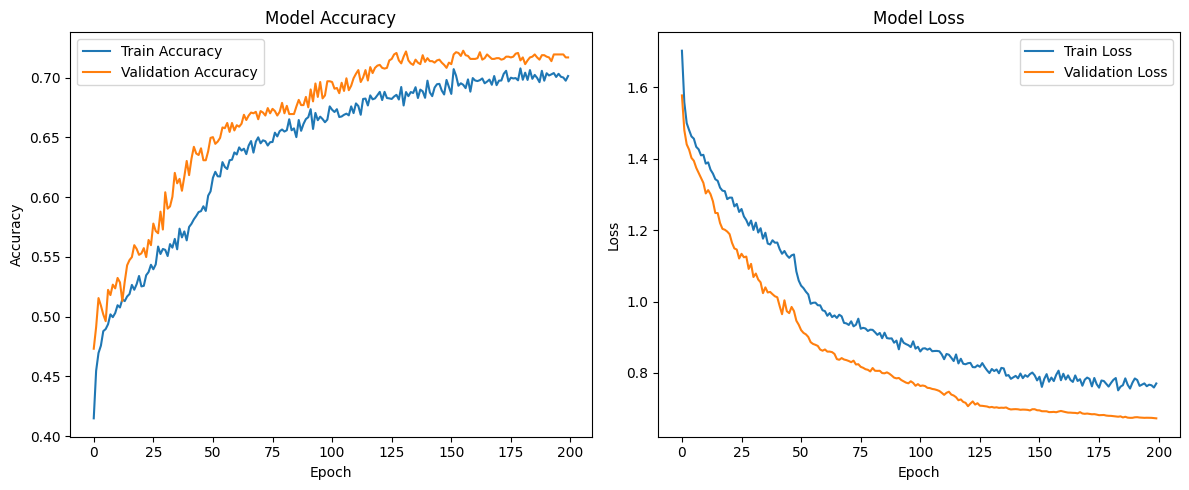

In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt  # matplotlib 임포트

# CSV 파일 경로
file_path = 'merged_travel_data.csv'

# CSV 파일 로드
df = pd.read_csv(file_path)

# 레이블 인코딩
le = LabelEncoder()
df['LODGING_TYPE_CD'] = le.fit_transform(df['LODGING_TYPE_CD'])

# 데이터 준비
X = df[['GENDER', 'AGE_GRP', 'TRAVEL_STYL_1', 'TRAVEL_STYL_4',
         'TRAVEL_STYL_5', 'TRAVEL_STYL_6', 'TRAVEL_STYL_8', 'TRAVEL_COMPANIONS_NUM']]
y = df['LODGING_TYPE_CD']

# 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 신경망 모델 생성
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(np.unique(y)), activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 콜백 정의
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 훈련
history = model.fit(X_train, y_train, epochs=200, batch_size=10, validation_split=0.2,
                    callbacks=[reduce_lr, early_stopping])

# 예측 및 평가
y_pred = np.argmax(model.predict(X_test), axis=-1)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}, F1 Score: {f1}")

# 모델 저장
model.save('best_tensorflow_model_type2.h5')

# TensorFlow Lite 변환
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# 최적화 옵션 추가 (양자화)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# TFLite 모델 변환
tflite_model = converter.convert()

# 변환된 TFLite 모델 저장
with open('model_type2.tflite', 'wb') as f:
    f.write(tflite_model)

print("TensorFlow Lite model saved as model.tflite")

# 정확도 및 손실 그래프 그리기
plt.figure(figsize=(12, 5))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4052 - loss: 1.7680 - learning_rate: 0.0010
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4776 - loss: 1.5768 - learning_rate: 0.0010
Epoch 3/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4814 - loss: 1.5721 - learning_rate: 0.0010
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4784 - loss: 1.5531 - learning_rate: 0.0010
Epoch 5/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4862 - loss: 1.5328 - learning_rate: 0.0010
Epoch 6/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4797 - loss: 1.5491 - learning_rate: 0.0010
Epoch 7/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4780 - loss: 1.5430 - learning_rate: 0.0010
Epoch 8/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4806 - loss: 1.5421 - learning_rate: 0.0010
Epoch 9/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4831 - loss: 1.5150 - learning_rate: 0.0010
Epoch 10/1

Accuracy: 0.4829375374176811, F1 Score: 0.314549546642656
Saved artifact at '/tmp/tmpr9bc5dri'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 8), dtype=tf.float32, name='keras_tensor_210')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  139111611744848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139111611746608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139111611751008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139111611753472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139111612309472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139111612315456: TensorSpec(shape=(), dtype=tf.resource, name=None)
TensorFlow Lite model saved as model_area.tflite


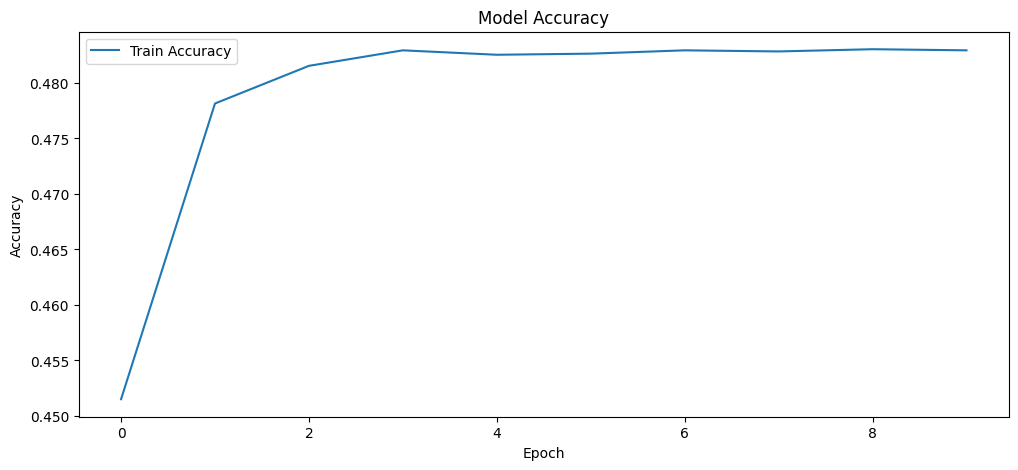

In [37]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

# CSV 파일 경로
file_path = 'merged_travel_data.csv'

# CSV 파일 로드
df = pd.read_csv(file_path)

# 레이블 인코딩
le = LabelEncoder()
df['VISIT_AREA_TYPE_CD'] = le.fit_transform(df['VISIT_AREA_TYPE_CD'])

# 데이터 준비
X = df[['GENDER', 'AGE_GRP', 'TRAVEL_STYL_1', 'TRAVEL_STYL_4',
         'TRAVEL_STYL_5', 'TRAVEL_STYL_6', 'TRAVEL_STYL_8', 'TRAVEL_COMPANIONS_NUM']]
y = df['VISIT_AREA_TYPE_CD']

# 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 신경망 모델 생성
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_scaled.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(np.unique(y)), activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 콜백 정의
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# 모델 훈련
history = model.fit(X_scaled, y, epochs=10, batch_size=42,
                    callbacks=[reduce_lr, early_stopping])

# 예측 및 평가
y_pred = np.argmax(model.predict(X_scaled), axis=-1)
accuracy = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred, average='weighted')

print(f"Accuracy: {accuracy}, F1 Score: {f1}")

# 모델 저장
model.save('best_tensorflow_model_area.h5')

# TensorFlow Lite 변환
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# 변환된 TFLite 모델 저장
with open('model_area.tflite', 'wb') as f:
    f.write(tflite_model)

print("TensorFlow Lite model saved as model_area.tflite")

# 정확도 그래프 그리기
plt.figure(figsize=(12, 5))

# 정확도 그래프
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
